# Environment

In [143]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from image_manipulation.models.conv_aec import LitConvAutoEncoder
from image_manipulation.models.vae import LitVAE
from image_manipulation.datasets.mnist import MnistDataset
from image_manipulation.scripts.utils import load_model_from_ckpt
import torch
from torchvision.utils import make_grid
import plotly.express as px
import pandas as pd
from torch_snippets import *

# Visualize latent space of conv autoencoder

In [24]:
# load model and MNIST val_dataloader
model_name = "conv_aec"
weights = "../training/conv_aec.ckpt"
model = load_model_from_ckpt(model_name, weights)
_, val_data = MnistDataset(batch_size=1).get_dataloaders()

In [25]:
# compute embeddings of val_data
embeddings = []
lbls = []
for im, lbl in val_data:
    embeddings.append(model.embeddings(im).view(len(im), -1))
    lbls.extend(lbl)
embeddings = torch.cat(embeddings).cpu().detach().numpy()

In [26]:
# convert in 2D space using tsne
tsne = TSNE(2)
clustered = tsne.fit_transform(embeddings)

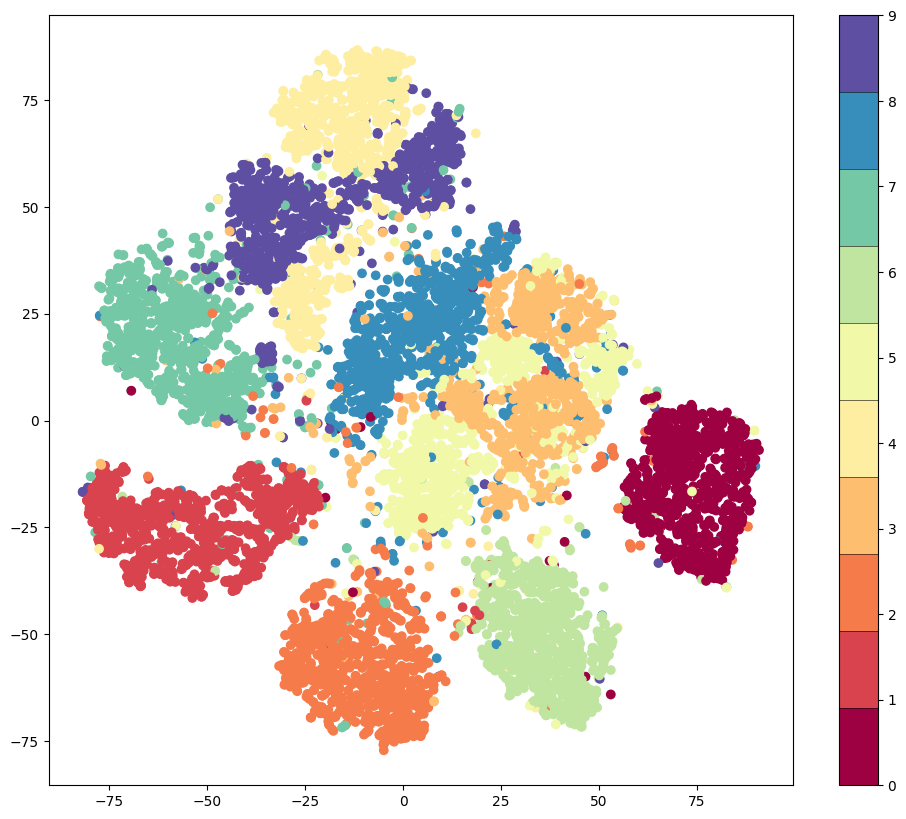

In [27]:
# plot data in 2D space
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=lbls, cmap=cmap)
plt.colorbar(drawedges=True)

In [28]:
# plot using plotly
clss = [x.item() for x in lbls]
idxs = list(range(len(clss)))
d = {
    "id": idxs,
    "label": clss,
    "x_embed": clustered[:,0],
    "y_embed": clustered[:,1]
}
df = pd.DataFrame.from_dict(d)
fig = px.scatter(
    df,
    x = "x_embed",
    y = "y_embed",
    hover_name="id",
    labels={"id": "id"},
    color="label"
)
fig.update_layout(height=800)
fig.show()
fig.write_html("tsne.html")

# Generate images from latent space of conv autoencoder

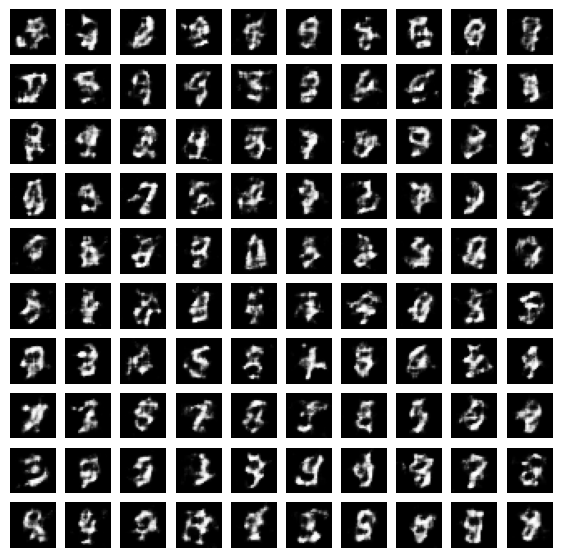

In [29]:
# generate random vectors from the latent space distribution
rand_vectors = []
for col in embeddings.transpose(1, 0):
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma * torch.randn(1,100) + mu)
rand_vectors = torch.cat(rand_vectors).transpose(1,0)

fig, ax = plt.subplots(10,10, figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1, 64, 2, 2)).view(28,28)
    show(img, ax=next(ax))

# Generate images from trained variational autoencoder

In [145]:
# load model and MNIST val_dataloader
model_name = "vae"
weights = "../training/vae.ckpt"
model = load_model_from_ckpt(model_name, weights)
_, val_data = MnistDataset(batch_size=1).get_dataloaders()

100%|██████████| 9912422/9912422 [00:00<00:00, 31844409.87it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26588168.09it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 18366267.25it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4634037.65it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



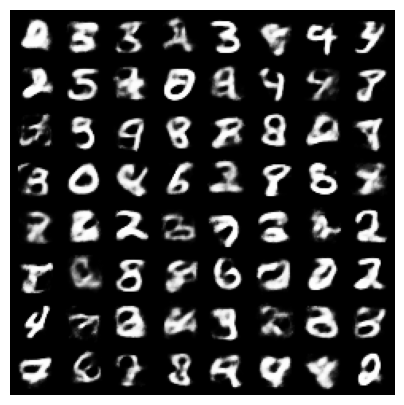

In [215]:
# generate images from random vector
z = torch.randn(64, 50)
sample = model.decoder(z)
grid = make_grid(sample.view(64, 1, 28, 28))
show(grid)